# Task 1: Exploratory Data Analytics 
a) Load the dataset and construct a feature vector for each article in the entire dataset. You need to report the number of articles, and the number of extracted features. Show 5 example articles with their extracted features using a dataframe.

In [117]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import log_loss
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)


In [118]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv("test.csv")
dataset = pd.concat([train_df, test_df])

X_train = train_df['Text']
y_train = train_df['Category']
X_test = test_df['Text']
y_test = test_df['Category']

vectorizer = CountVectorizer(stop_words='english')

# Convert string labels to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Apply PCA to reduce the dimensionality to 2
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())


X_split_train, X_split_test, y_split_train, y_split_test = train_test_split(train_df['Text'], train_df['Category'], test_size=0.2, random_state=1)
X_train_vec = vectorizer.fit_transform(X_split_train)
X_test_vec = vectorizer.transform(X_split_test)

y_train_encoded = label_encoder.fit_transform(y_train)
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
y_test_encoded = label_encoder.transform(y_test)

vectorizer = CountVectorizer()

corpus = dataset['Text'].tolist()
vectorizer.fit(corpus)

feature_vectors = vectorizer.transform(corpus)

num_articles = feature_vectors.shape[0]

num_features = feature_vectors.shape[1]

print("Number of Articles:", num_articles)
print("Number of Extracted Features:", num_features)

example_articles = dataset.head(5).copy()
example_articles['Features'] = [vector.toarray().tolist() for vector in feature_vectors[:5]]

print(example_articles)

Number of Articles: 534
Number of Extracted Features: 14927
   ArticleId                                               Text  \
0       1976  lifestyle governs mobile choice faster better ...   
1       1797  french honour director parker british film dir...   
2       1866  fockers fuel festive film chart comedy meet fo...   
3       1153  housewives lift channel 4 ratings debut us tel...   
4        342  u2 desire number one u2 three prestigious gram...   

        Category                                           Features  
0           tech  [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
1  entertainment  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
2  entertainment  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
3  entertainment  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
4  entertainment  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  


(b) Conduct term frequency analysis and report three plots: (i) top-50 term frequency distribution across the entire dataset, (ii) term frequency distribution for respective class of articles, and (iii) class distribution.

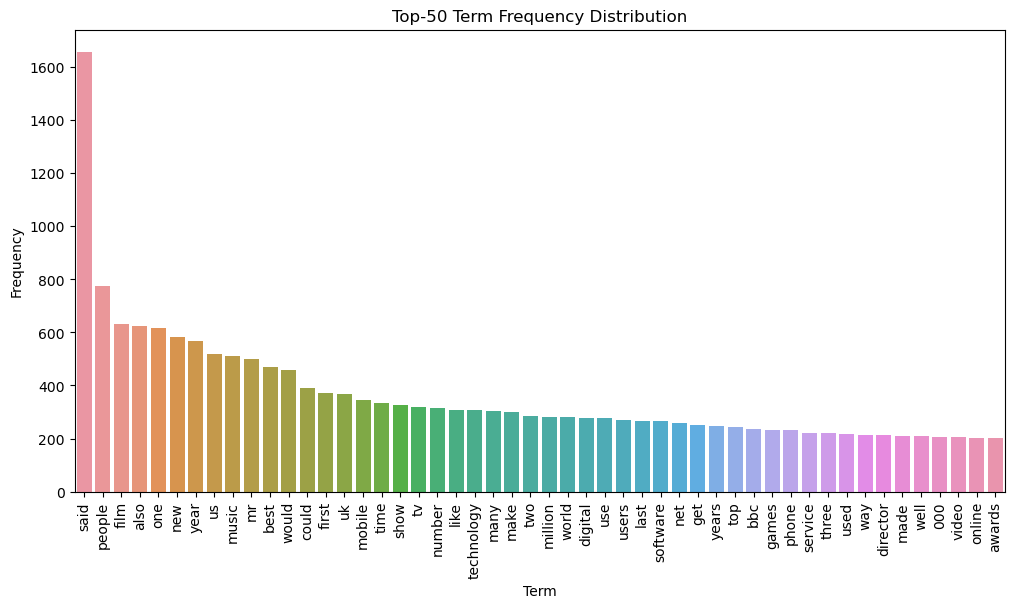

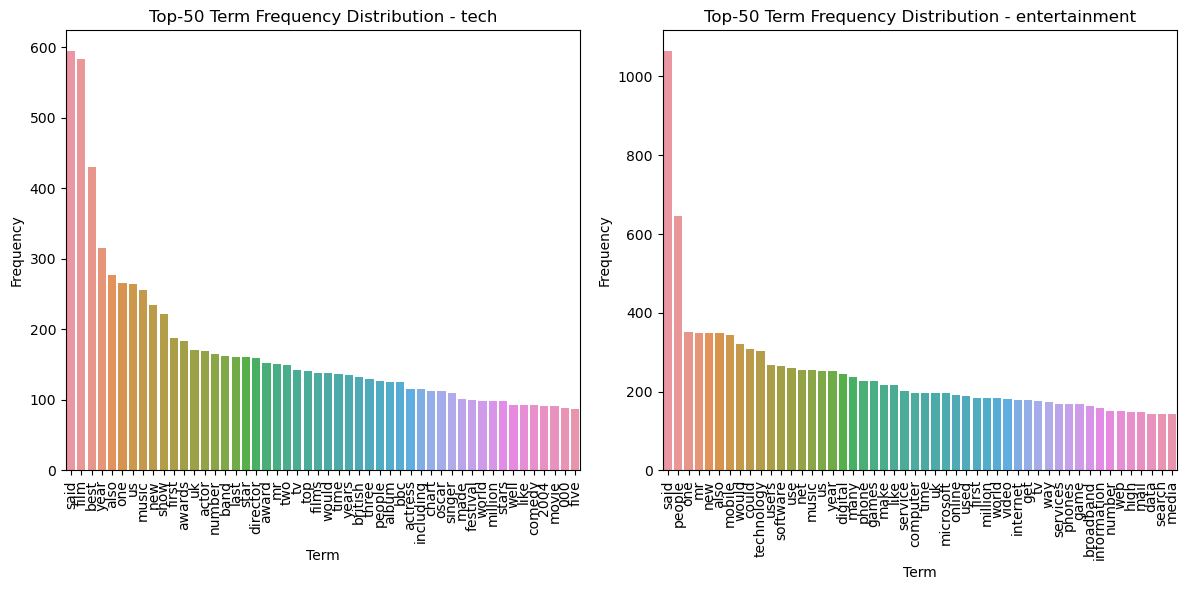

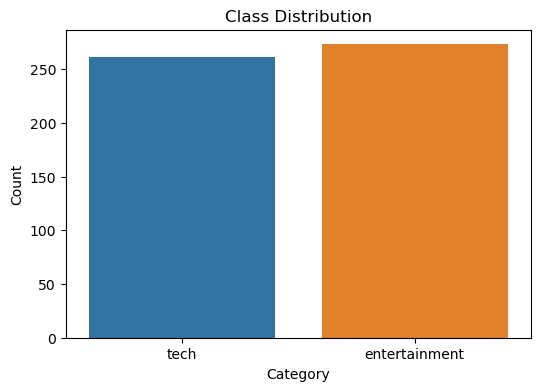

In [119]:
term_frequencies = feature_vectors.sum(axis=0)

term_freq_list = term_frequencies.tolist()[0]
vocabulary = vectorizer.get_feature_names_out()

df_term_freq = pd.DataFrame({'Term': vocabulary, 'Frequency': term_freq_list})
df_term_freq = df_term_freq.sort_values('Frequency', ascending=False).head(50)

# Plot the top-50 term frequency distribution
plt.figure(figsize=(12, 6))
sns.barplot(data=df_term_freq, x='Term', y='Frequency')
plt.xticks(rotation=90)
plt.xlabel('Term')
plt.ylabel('Frequency')
plt.title('Top-50 Term Frequency Distribution')
plt.show()

class_term_frequencies = dataset.groupby('Category')['Text'].apply(lambda x: vectorizer.transform(x.tolist()).sum(axis=0))
class_labels = dataset['Category'].unique()

# Plot the top-50 term frequency distribution for each class
plt.figure(figsize=(12, 6))
for i, label in enumerate(class_labels):
    term_freq = class_term_frequencies[i]
    term_freq_list = term_freq.tolist()[0]
    df_class_term_freq = pd.DataFrame({'Term': vocabulary, 'Frequency': term_freq_list})
    df_class_term_freq = df_class_term_freq.sort_values('Frequency', ascending=False).head(50)
    plt.subplot(1, len(class_labels), i+1)
    sns.barplot(data=df_class_term_freq, x='Term', y='Frequency')
    plt.title(f'Top-50 Term Frequency Distribution - {label}')
    plt.xlabel('Term')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot the class distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=dataset, x='Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()


# Task 2: Classification Models Learning
(a) Train a Naive Bayes classifier using all articles features. Report the (i) top-20 most identifiable words that are most likely to occur in the articles over two classes using your NB
classifier, and (ii) the top-20 words that maximize the following quantity: 𝑷(𝑿𝒘=𝟏|𝒀=𝒚) / 𝑷(𝑿𝒘=𝟏|𝒀≠𝒚)
Which list of words describe the two classes better? Briefly explain your reasoning.

In [120]:
classifier = MultinomialNB()


labels_nb = dataset['Category']
text = vectorizer.fit_transform(dataset['Text'])
classifier.fit(text, labels_nb)

feature_log_probs = classifier.feature_log_prob_

top_20_words_per_class = []
for class_index, class_name in enumerate(classifier.classes_):
    class_feature_log_probs = feature_log_probs[class_index]
    top_20_indices = np.argsort(class_feature_log_probs)[::-1][:20]
    top_20_words = [vocabulary[index] for index in top_20_indices]
    top_20_words_per_class.append((class_name, top_20_words))

print("The top 20 most identifiable words that are most likely to occur in the articles over two classes are:\n")

for class_name, top_words in top_20_words_per_class:
    print(f"Class: {class_name}")
    print("Top 20 Words:", top_words)
    print()

numerator_probs = np.exp(feature_log_probs)
denominator_probs = numerator_probs.sum(axis=0) - numerator_probs

quantity_per_class = numerator_probs / denominator_probs

top_20_words_per_class = []
for class_index, class_name in enumerate(classifier.classes_):
    quantity_class = quantity_per_class[class_index]
    top_20_indices = np.argsort(quantity_class)[::-1][:20]
    top_20_words = [vocabulary[index] for index in top_20_indices]
    top_20_words_per_class.append((class_name, top_20_words))

print("The top 20 words that maximize the following quantity: 𝑷(𝑿𝒘=𝟏|𝒀=𝒚) / 𝑷(𝑿𝒘=𝟏|𝒀≠𝒚) are:\n")

for class_name, top_words in top_20_words_per_class:
    print(f"Class: {class_name}")
    print("Top 20 Words:", top_words)
    print()



The top 20 most identifiable words that are most likely to occur in the articles over two classes are:

Class: entertainment
Top 20 Words: ['said', 'film', 'best', 'year', 'also', 'one', 'us', 'music', 'new', 'show', 'first', 'awards', 'uk', 'actor', 'number', 'band', 'star', 'last', 'director', 'award']

Class: tech
Top 20 Words: ['said', 'people', 'one', 'new', 'mr', 'also', 'mobile', 'would', 'could', 'technology', 'users', 'software', 'use', 'net', 'music', 'us', 'year', 'digital', 'many', 'phone']

The top 20 words that maximize the following quantity: 𝑷(𝑿𝒘=𝟏|𝒀=𝒚) / 𝑷(𝑿𝒘=𝟏|𝒀≠𝒚) are:

Class: entertainment
Top 20 Words: ['actress', 'oscar', 'festival', 'nominated', 'aviator', 'nominations', 'album', 'starring', 'oscars', 'stars', 'charles', 'foxx', 'singles', 'died', 'actor', 'dance', 'vera', 'sideways', 'jamie', 'dollar']

Class: tech
Top 20 Words: ['users', 'software', 'microsoft', 'mobile', 'broadband', 'firms', 'virus', 'pc', 'spam', 'mobiles', 'gadgets', 'google', 'net', 'phone

The second list of words describe the two classes better because it contains more informative words for each class compared to the first list of words that contain more general but frequent words such as 'said', 'new' and 'one'.

(b) kNN. Train a kNN classifier on the training dataset. You need to report the surface plot of your kNN with your choice of hyperparameters k and distance metric. Explain the impact of k and the distance metric on the decision boundary.

Text(0, 0.5, 'Accuracy')

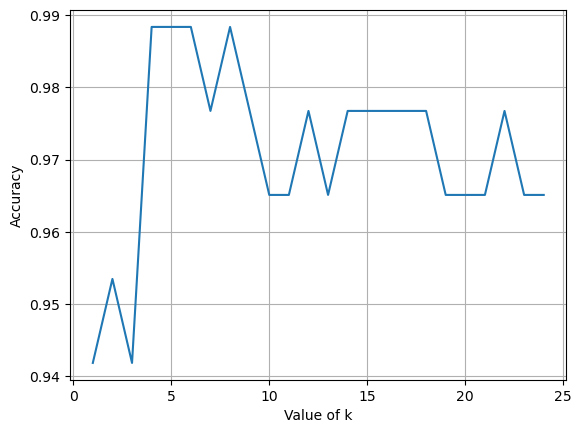

In [112]:
#Import data and create a bag of words for text column 
#dataset = pd.read_csv('train.csv')

#Tuning k for Euclidean distance
k_range = range(1, 25)
scores_Euclidean = {}
list_scores_Euclidean = []
for k in k_range:
    knn_Euclidean = KNeighborsClassifier(n_neighbors=k, p=2, metric='minkowski')
    knn_Euclidean.fit(X_train_vec, y_split_train)
    y_pred = knn_Euclidean.predict(X_test_vec)
    scores_Euclidean[k] = metrics.accuracy_score(y_split_test, y_pred)
    list_scores_Euclidean.append(metrics.accuracy_score(y_split_test, y_pred))

plt.plot(k_range, list_scores_Euclidean)
plt.grid()
plt.xlabel('Value of k')
plt.ylabel('Accuracy')


Text(0, 0.5, 'Accuracy')

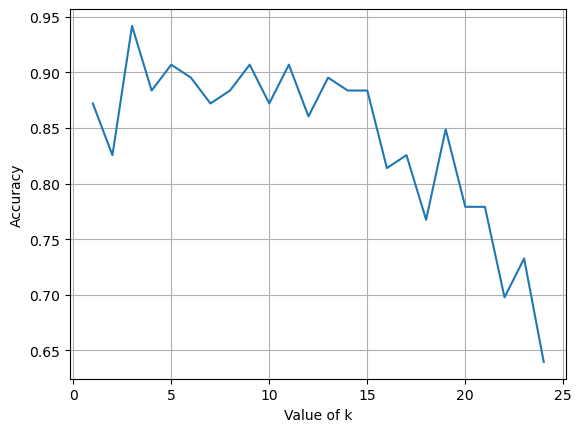

In [115]:
#Tuning k for Manhattan distance
scores_Manhattan = {}
list_scores_Manhattan = []
for k in k_range:
    knn_Manhattan = KNeighborsClassifier(n_neighbors=k, p=1, metric='minkowski')
    knn_Manhattan.fit(X_train_vec, y_split_train)
    y_pred = knn_Manhattan.predict(X_test_vec)
    scores_Manhattan[k] = metrics.accuracy_score(y_split_test, y_pred)
    list_scores_Manhattan.append(metrics.accuracy_score(y_split_test, y_pred))

plt.plot(k_range, list_scores_Manhattan)
plt.grid()
plt.xlabel('Value of k')
plt.ylabel('Accuracy')

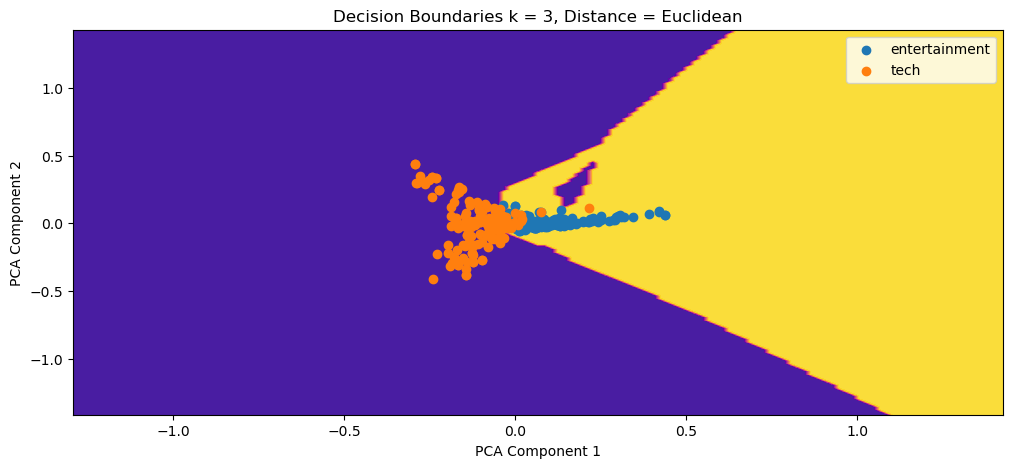

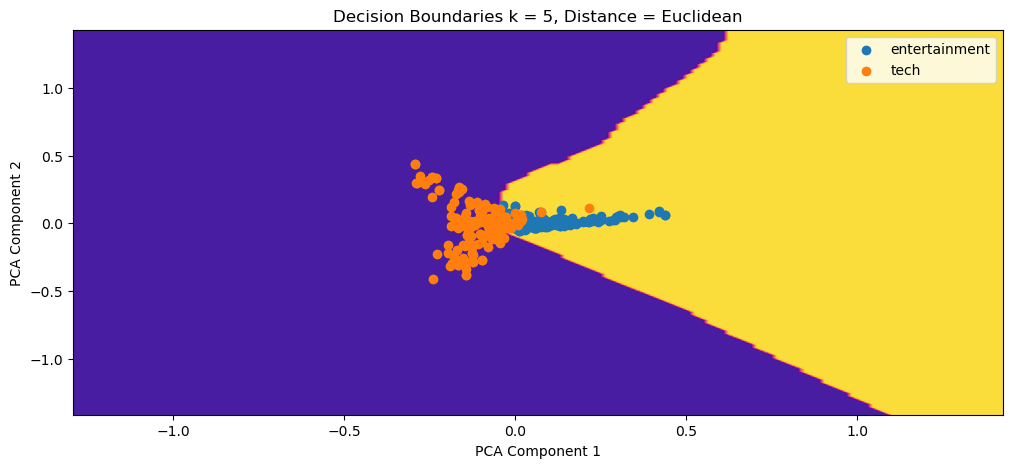

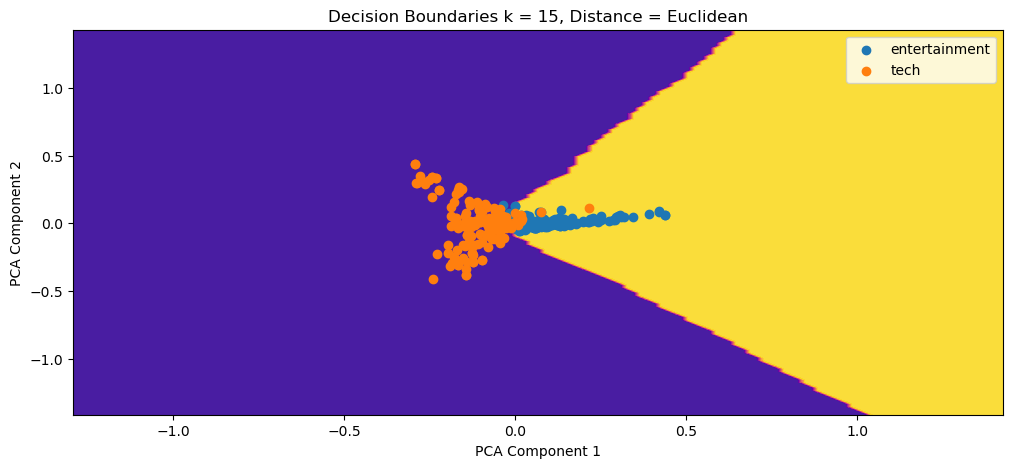

In [85]:
#Plot decision boundary using a couple of k values (based on Euclidean and Manhattan distances)

#Change class labels to integer
label_dict = {'tech': 0, 'entertainment': 1}
X_split_train['ClassLabel'] = y_split_train.map(label_dict)

#Dimensionality reduction with PCA
features = X_train_vec.toarray()
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

#Training the KNN model uing Euclidean distance
ks = [3, 5, 15]
knns = {}
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k, p=2, metric='minkowski')
    knn.fit(reduced_features, X_split_train['ClassLabel'])
    knns[k] = knn

#Plot
h = 0.02  #Step size in the mesh
x_min, x_max = reduced_features[:, 0].min() - 1, reduced_features[:, 0].max() + 1
y_min, y_max = reduced_features[:, 1].min() - 1, reduced_features[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
for k, knn in knns.items():
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(12, 5)) 
    plt.contourf(xx, yy, Z, alpha=0.9, cmap='plasma')

#Plot the training points
    for i, label in enumerate(set(y_split_train)):
        indices = np.where(np.array(y_split_train) == label)[0]
        plt.scatter(reduced_features[indices, 0], reduced_features[indices, 1], label=label)

    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(f'Decision Boundaries k = {k}, Distance = Euclidean')
    plt.legend()
    plt.show()


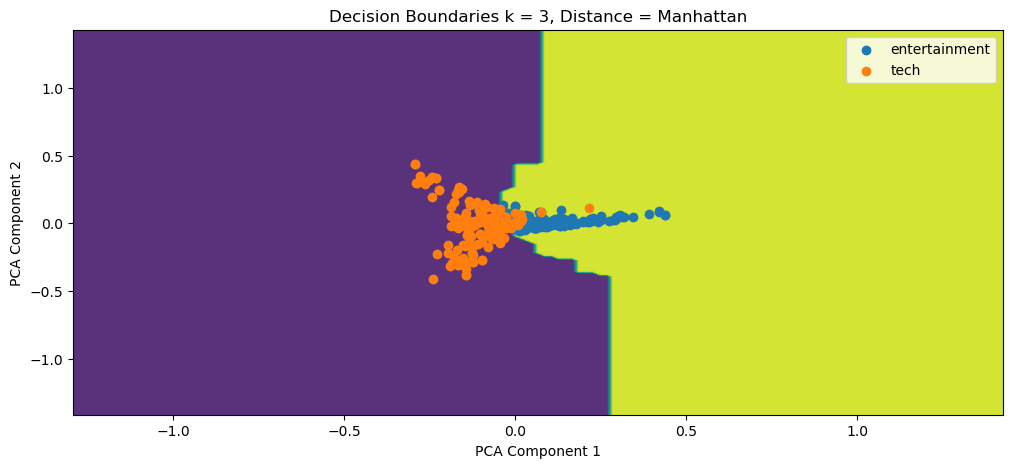

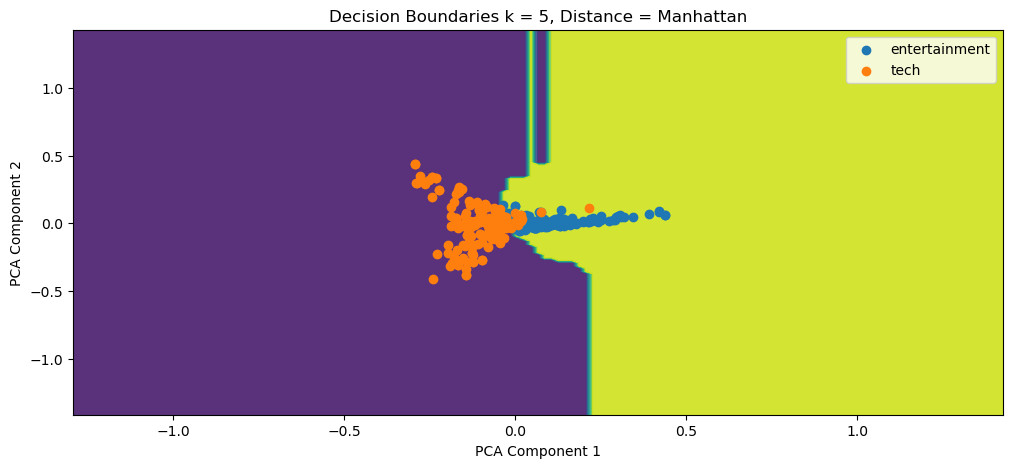

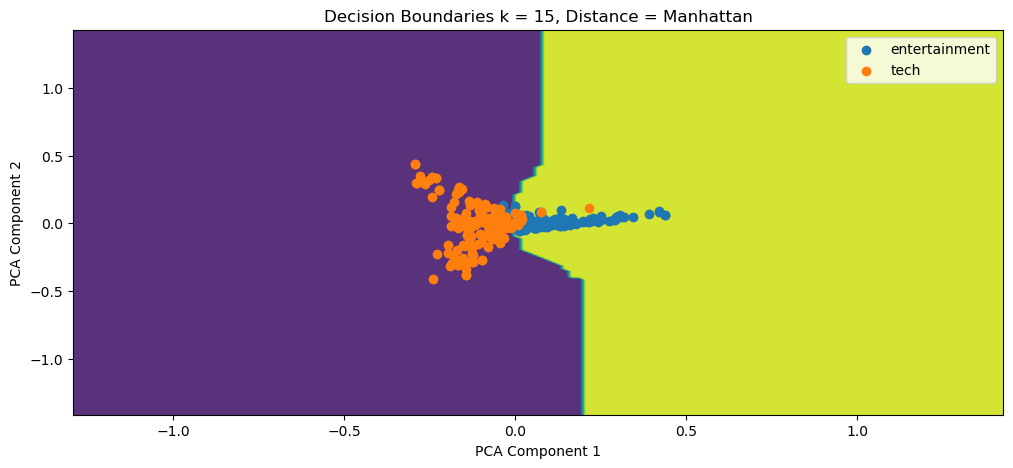

In [86]:
#Training the KNN model using Manhattan distance
knns_Manhattan = {}
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k, p=1, metric='minkowski')
    knn.fit(reduced_features, X_split_train['ClassLabel'])
    knns_Manhattan[k] = knn

#Plot
for k, knn in knns_Manhattan.items():
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(12, 5)) 
    plt.contourf(xx, yy, Z, alpha=0.9, cmap='viridis')

#Plot the training points
    for i, label in enumerate(set(y_split_train)):
        indices = np.where(np.array(y_split_train) == label)[0]
        plt.scatter(reduced_features[indices, 0], reduced_features[indices, 1], label=label)

    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(f'Decision Boundaries k = {k}, Distance = Manhattan')
    plt.legend()
    plt.show()

As the value of K increases, the decision boundary becomes more refined and tends towards underfitting. Conversely, using a very small K value leads to overfitting, as observed in the case of K=3 for both distance metrics. Therefore, selecting an intermediate K value is essential for striking a balance between bias and variance. Consequently, opting for K=5 is a favorable choice for determining the number of neighbors.

Manhattan distance is more robust to sparse data and less sensitive to outliers, which are commonly encountered in text classification tasks. Although the preference for Manhattan distance over Euclidean distance is often emphasized in scenarios involving high dimensionality, the boundary plots reveal a negligible disparity between the two metrics. Furthermore, the accuracy plots demonstrate superior performance of the K-nearest neighbors (KNN) algorithm employing Euclidean distance on the given dataset.


(c) SVM. Train two SVM classification models (soft-margin linear SVM and hard-margin RBF kernel SVM) on the training dataset. You need to report two surface plots for: (i) the soft-margin linear SVM with your choice of misclassification penalty (𝐶𝐶), and (ii) the hard-margin RBF kernel with your choice of kernel width (σ). Explain the impact of penalty 𝐶𝐶 on the soft-margin decision boundaries, as well as the kernel hyperparameter on the hard-margin decision boundaries.

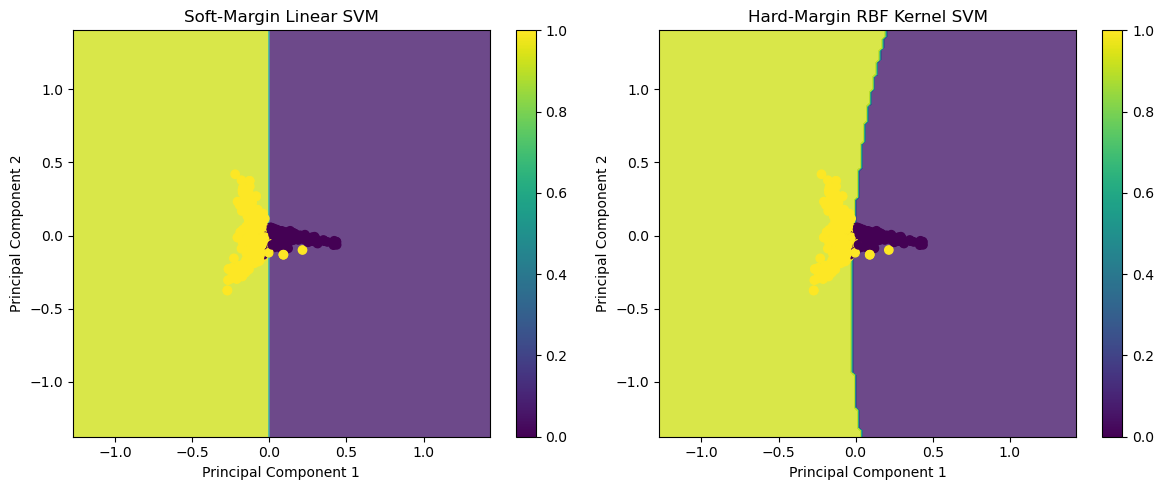

In [87]:

# Train the linear SVM classifier
linear_svm = LinearSVC()
linear_svm.fit(X_train_pca, y_train_encoded)


# Load the training dataset into a DataFrame
train_df = pd.read_csv('train.csv')  # Replace 'train.csv' with the actual file path or name
test_df = pd.read_csv('test.csv')  # Replace 'test.csv' with the actual file path or name
X_train = train_df['Text'].values
y_train = train_df['Category'].values
X_test = test_df['Text'].values
y_test = test_df['Category'].values

# Convert string labels to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Apply PCA to reduce the dimensionality to 2
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())


# Train the RBF kernel SVM classifier
C = 1  # Penalty parameter (you can adjust this value)
sigma = 1  # Kernel width (you can adjust this value)
rbf_svm = SVC(C=C, kernel='rbf', gamma=1 / (2 * sigma ** 2))
rbf_svm.fit(X_train_pca, y_train_encoded)

X_test_pca = pca.transform(X_test_tfidf.toarray())
y_test_encoded = label_encoder.transform(y_test)

# Evaluate the models on the test data
linear_svm_predictions = linear_svm.predict(X_test_pca)
linear_svm_accuracy = accuracy_score(y_test_encoded, linear_svm_predictions)

rbf_svm_predictions = rbf_svm.predict(X_test_pca)
rbf_svm_accuracy = accuracy_score(y_test_encoded, rbf_svm_predictions)

# Plotting the decision boundaries and data points
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Soft-margin Linear SVM decision boundary
Z_linear = linear_svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z_linear = Z_linear.reshape(xx.shape)

# RBF Kernel SVM decision boundary
Z_rbf = rbf_svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z_rbf = Z_rbf.reshape(xx.shape)
plt.figure(figsize=(12, 5))

# Soft-margin Linear SVM decision boundary plot
plt.subplot(1, 2, 1)
plt.contourf(xx, yy, Z_linear, alpha=0.8, cmap='viridis')
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_encoded, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Soft-Margin Linear SVM')
plt.colorbar(scatter)

# RBF Kernel SVM decision boundary plot
plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z_rbf, alpha=0.8, cmap='viridis')
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_encoded, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Hard-Margin RBF Kernel SVM')
plt.colorbar(scatter)

plt.tight_layout()
plt.show()

The penalty parameter (C) in the soft-margin SVM controls the balance between margin size and misclassification, while the kernel hyperparameter (sigma) in the hard-margin RBF kernel SVM determines the width of the Gaussian kernel and its influence on the decision boundary. Adjusting these parameters can have significant impacts on the decision boundaries and the model's ability to generalize and handle different types of data distributions. It is crucial to tune these parameters carefully based on the specific problem and dataset to achieve optimal performance.

(d) NN. Consider a neural network with the following hyperparameters: the initial weights uniformly drawn in range [0,0.1] with learning rate 0.01.
● Train a single hidden layer neural network using the hyperparameters on the training dataset, except for the number of hidden units (x) which should vary among 5, 20, and 40. Run the optimization for 100 epochs each time. Namely, the input layer consists of n features x = [x1, ..., xn]T , the hidden layer has x nodes z = [z1, ..., zx]T , and the output layer is a probability distribution y = [y1, y2]T over two classes.
● Plot the average training cross-entropy loss as shown below on the y-axis versus the number of hidden units on the x-axis. Explain the effect of numbers of hidden units.


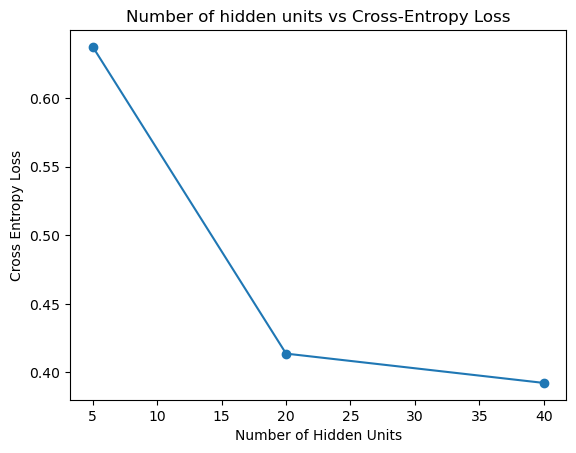

In [88]:
cross_entropy_loss = []
layer_sizes = [5, 20, 40]

for i in layer_sizes:
  MLP = MLPClassifier(hidden_layer_sizes=(i), solver='sgd', learning_rate_init=0.01, max_iter=100, random_state=666)
  MLP.fit(X_train_tfidf, y_train_encoded)
  predictions = MLP.predict(X_test_tfidf)

  cross_entropy_loss.append(log_loss(y_test, MLP.predict_proba(X_test_tfidf)))

plt.plot(layer_sizes, cross_entropy_loss,  marker='o')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Cross Entropy Loss')
plt.title('Number of hidden units vs Cross-Entropy Loss')
plt.show()

Increasing the number of hidden units in a neural network can enhance its ability to learn complex patterns and reduce the entropy loss. This initial decrease in entropy loss signifies improved fitting of the training data. However, excessive hidden units can lead to overfitting, where the network memorizes the training examples instead of learning underlying patterns. This can cause a continued decrease in entropy loss but may result in poor generalization performance on unseen data.

# Task 3: Classification Quality Evaluation

(a) We explore how the size of the training data set affects the test and train accuracy. For each value of m in [0.1, 0.3, 0.5, 0.7, 0.9], train your classifier on the first m portion of the training examples (that is, use the data given by XTrain[0:mN] and yTrain[0:mN]). Please report two plots: (i) training and (ii) testing accuracy for each such value of m with the x-axis referring to m and the y-axis referring to the classification accuracy in 𝐹𝐹1 measure as shown below. In total, there should be four curves for training accuracy and four curves for testing accuracy. Explain the general trend of the two plots in terms of training and testing accuracy if any.

In [121]:
#functions to compute accuracy
def test_train_acc(classifier, m, dataset, testset):
    train_accuracy = []
    test_accuracy = []

    for size in m:
        vectorizer = CountVectorizer()
        X_train = dataset['Text'][:int(size * len(dataset['Text']))]
        y_train = dataset['Category'][:int(size * len(dataset['Category']))]
        
        X_train_vec = vectorizer.fit_transform(X_train)
        X_test_vec = vectorizer.transform(X_train)
        test_vec = vectorizer.transform(testset['Text'])
        
        classifier.fit(X_train_vec, y_train)
        
        train_predictions = classifier.predict(X_test_vec)
        test_predictions = classifier.predict(test_vec)
        
        train_f1 = f1_score(y_train, train_predictions, average='macro')
        test_f1 = f1_score(testset['Category'], test_predictions, average='macro')
        
        train_accuracy.append(train_f1)
        test_accuracy.append(test_f1)
    return train_accuracy, test_accuracy

#separate function for NN model
def test_train_acc_nn(classifier, m, dataset, testset):
    X_train = dataset['Text']
    y_train = dataset['Category']
    X_test = testset['Text']
    y_test = testset['Category']

    # Encode the labels
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)

    # Initialize the TF-IDF vectorizer
    vectorizer = TfidfVectorizer()

    # Fit and transform the training data
    X_train_vec = vectorizer.fit_transform(X_train).toarray()

    # Transform the test data
    X_test_vec = vectorizer.transform(X_test).toarray()

    train_accuracy = []
    test_accuracy = []

    for size in m:
        num_samples = int(size * len(X_train))
        X_train_subset = X_train[:num_samples].tolist()
        y_train_subset = y_train[:num_samples]
        
        X_train_subset_vec = vectorizer.fit_transform(X_train_subset).toarray()
        X_test_subset_vec = vectorizer.transform(X_train_subset).toarray()
        test_vec = vectorizer.transform(X_test).toarray()
        
        classifier.fit(X_train_subset_vec, y_train_subset)
        
        train_predictions = classifier.predict(X_test_subset_vec)
        test_predictions = classifier.predict(test_vec)
        
        train_f1 = f1_score(y_train_subset, train_predictions, average='macro')
        test_f1 = f1_score(y_test, test_predictions, average='macro')
        
        train_accuracy.append(train_f1)
        test_accuracy.append(test_f1)
        
    return train_accuracy, test_accuracy

In [122]:
#preprocessing data for consistency
dataset = pd.read_csv("train.csv")
testset = pd.read_csv("test.csv")

stop_words = set(stopwords.words('english'))
dataset['Text'] = dataset['Text'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word.lower() not in stop_words and word.lower() not in punctuation]))
testset['Text'] = testset['Text'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word.lower() not in stop_words and word.lower() not in punctuation]))

m = [0.1, 0.3, 0.5, 0.7, 0.9]


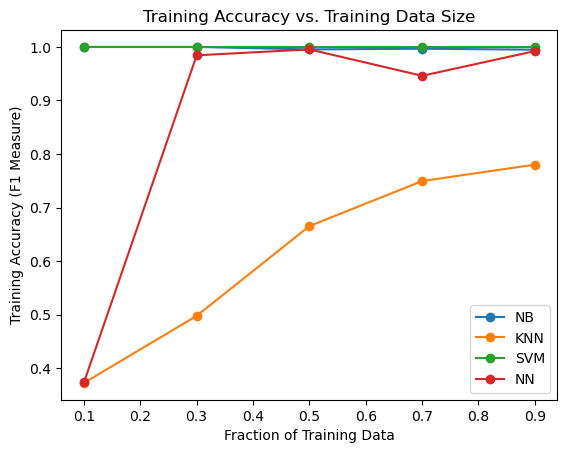

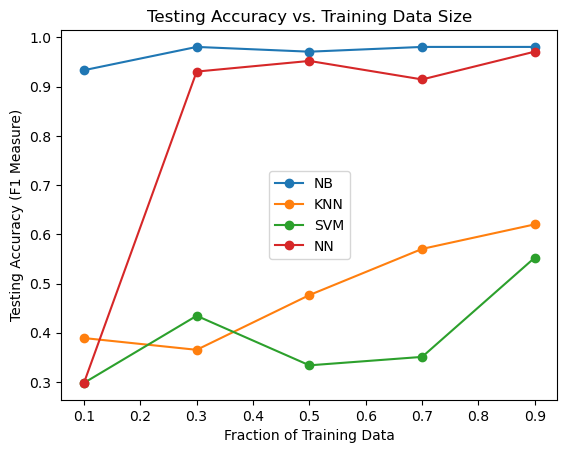

In [127]:

#computing accuracy for each model
train_accuracy_nb, test_accuracy_nb = test_train_acc(MultinomialNB(), m, dataset, testset)
train_accuracy_knn, test_accuracy_knn = test_train_acc(KNeighborsClassifier(n_neighbors=5, p=1, metric='minkowski'), m, dataset, testset)
train_accuracy_svm, test_accuracy_svm = test_train_acc(SVC(C=1, kernel='rbf', gamma=1 / (2 * 1 ** 2)), m, dataset, testset)
train_accuracy_nn, test_accuracy_nn = test_train_acc_nn(MLPClassifier(hidden_layer_sizes=(40), solver='sgd', 
                                                                      learning_rate_init=0.01, max_iter=100), m, dataset, testset)

plt.plot(m, train_accuracy_nb, marker='o', label = 'NB')
plt.plot(m, train_accuracy_knn, marker='o', label = 'KNN')
plt.plot(m, train_accuracy_svm, marker='o', label = 'SVM')
plt.plot(m, train_accuracy_nn, marker='o', label = 'NN')
plt.xlabel('Fraction of Training Data')
plt.ylabel('Training Accuracy (F1 Measure)')
plt.title('Training Accuracy vs. Training Data Size')
plt.legend()
plt.show()

plt.plot(m, test_accuracy_nb, marker='o', label = "NB")
plt.plot(m, test_accuracy_knn, marker='o', label = "KNN")
plt.plot(m, test_accuracy_svm, marker='o', label = 'SVM')
plt.plot(m, test_accuracy_nn, marker='o', label = "NN")
plt.xlabel('Fraction of Training Data')
plt.ylabel('Testing Accuracy (F1 Measure)')
plt.title('Testing Accuracy vs. Training Data Size')
plt.legend()
plt.show()

## Discussion
As observed in the plots above, Naive Bayes Classifier outperforms the other three models for test and training accuracy on all portions of training data. We can also see that predictions using the Neural Network Classifier had the biggest improvement in accuracy. Naive Bayes is known for being a great text-classification model, but it could be that with a larger dataset, the Neural Network model would achieve a better score. K-Nearest Neighbours Classifier had the lowest F1-score on the training set, but with a larger training set, its test accuracy improved to the point of performing better than the Support Vector Classifier.

(b) Let’s use 5-fold cross-validation to assess model performance. Investigate the impact of key hyperparameters of your choices for each classifier using a testing dataset. E.g., for SVM, the classification accuracy may be significantly affected by the kernels and hyperparameter combination. List hyperparameters for each classifier and demonstrate how these hyperparameters impact on the testing accuracy.

In [123]:
#(for consistency) preprocess data
dataset = pd.read_csv("train.csv")
testset = pd.read_csv("test.csv")

stop_words = set(stopwords.words('english'))
dataset['Text'] = dataset['Text'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word.lower() not in stop_words and word.lower() not in punctuation]))
testset['Text'] = testset['Text'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word.lower() not in stop_words and word.lower() not in punctuation]))

X_train = dataset['Text']
y_train = dataset['Category']

vectorizer = CountVectorizer()

X_train_vec = vectorizer.fit_transform(dataset['Text'])
test_vec = vectorizer.transform(testset['Text'])
y_test = testset['Category']


### NB Cross-Validation

In [92]:
#function to compute TestAcc for every tested hyperparameter
def get_test_score_nb(alpha, X_train_vec, y_train, X_test_vec, y_test):
    return MultinomialNB(alpha = alpha).fit(X_train_vec, y_train).score(X_test_vec, y_test)
    

#set hyperparameters to test and fit model to GridSearchCV
nb = MultinomialNB()

nb_grid = {'alpha': [0.0001,0.001,0.01,0.1,1,10,10,100,1000,10000]}

nb_cv = GridSearchCV(estimator = MultinomialNB(), param_grid = nb_grid, cv = 5, return_train_score = True, scoring = 'accuracy')
nb_cv.fit(X_train_vec, y_train)
nb_cv_res = pd.DataFrame(nb_cv.cv_results_)


#build df with accuracy scores
nb_cv_fin = nb_cv_res[['param_alpha', 'mean_train_score', 'mean_test_score']]
nb_cv_fin = nb_cv_fin.rename(columns = {'param_alpha': 'alpha', 
                                        'mean_train_score': 'TrainAcc', 
                                        'mean_test_score': 'ValAcc'})
nb_cv_fin['TestAcc'] = nb_cv_fin.apply(lambda x: get_test_score_nb(x.alpha, X_train_vec, y_train, test_vec, y_test), axis=1)

#final df
nb_cv_fin

,alpha,TrainAcc,ValAcc,TestAcc
0,0.0001,1.000000,0.979042,0.990566
1,0.001,1.000000,0.979042,0.990566
2,0.01,0.998247,0.986019,0.981132
3,0.1,0.997664,0.986019,0.981132
4,1,0.996495,0.981368,0.971698
5,10,0.987735,0.955732,0.971698
6,10,0.987735,0.955732,0.971698
7,100,0.921146,0.871710,0.915094
8,1000,0.842298,0.803912,0.839623
9,10000,0.790899,0.759535,0.773585


In [93]:
print('Best Hyperparameters: ', nb_cv.best_params_)
print('Test Accuracy on best Model: ', nb_cv.best_estimator_.score(test_vec, y_test))
#this is due to overfitting: we want the hyperparameters that not only maximise accuracy 
#but also have the most similar values in terms of accuracy scores for training, validation and test sets.

Best Hyperparameters:  {'alpha': 0.01}
Test Accuracy on best Model:  0.9811320754716981


### kNN Cross-Validation

In [94]:
def get_test_score_knn(metric, n, X_train_vec, y_train, X_test_vec, y_test):
    return KNeighborsClassifier(n_neighbors = n, p = 1, metric = metric).fit(X_train_vec, y_train).score(X_test_vec, y_test)

knn = KNeighborsClassifier()
knn_grid = {'n_neighbors': [3, 5, 15, 21, 31],
            'metric': ['euclidean', 'manhattan']
             }

knn_cv = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = knn_grid, cv = 5, return_train_score = True, scoring = 'accuracy')
knn_cv.fit(X_train_vec, y_train)
knn_cv_res = pd.DataFrame(knn_cv.cv_results_)

#knn_cv_res
knn_cv_fin = knn_cv_res[['param_metric', 'param_n_neighbors', 'mean_train_score', 'mean_test_score']]
knn_cv_fin = knn_cv_fin.rename(columns = {'param_metric': 'metric', 
                                          'param_n_neighbors': 'n_neighbors', 
                                          'mean_train_score': 'TrainAcc', 
                                          'mean_test_score': 'ValAcc'})
knn_cv_fin['TestAcc'] = knn_cv_fin.apply(lambda x: get_test_score_knn(x.metric, x.n_neighbors, X_train_vec, y_train, test_vec, y_test), axis=1)
knn_cv_fin


,metric,n_neighbors,TrainAcc,ValAcc,TestAcc
0,euclidean,3,0.846388,0.738249,0.801887
1,euclidean,5,0.773362,0.719590,0.754717
2,euclidean,15,0.595199,0.570041,0.669811
3,euclidean,21,0.544386,0.544350,0.632075
4,euclidean,31,0.515186,0.509330,0.603774
5,manhattan,3,0.834104,0.719781,0.754717
6,manhattan,5,0.754076,0.656607,0.688679
7,manhattan,15,0.543793,0.511683,0.594340
8,manhattan,21,0.504663,0.504651,0.575472
9,manhattan,31,0.495910,0.495321,0.575472


In [95]:
print('Best Hyperparameters: ', knn_cv.best_params_)
print('Test Accuracy on best Model: ', knn_cv.score(test_vec, y_test))

Best Hyperparameters:  {'metric': 'euclidean', 'n_neighbors': 3}
Test Accuracy on best Model:  0.8018867924528302


### SVM Cross-Validation

In [96]:
def get_test_score_svm(C, gamma, kernel, X_train_vec, y_train, X_test_vec, y_test):
    return SVC(C = C, kernel = kernel, gamma = gamma).fit(X_train_vec, y_train).score(X_test_vec, y_test)

svm = SVC()

sigma_values = [0.1, 1, 10]
svm_grid = {'C': [0.1, 1, 10],
           'gamma': [1 / (2 * sigma ** 2) for sigma in sigma_values],
           'kernel': ['linear', 'rbf']
             }

svm_cv = GridSearchCV(estimator = SVC(), param_grid = svm_grid, cv = 5, return_train_score = True, scoring = 'accuracy')
svm_cv.fit(X_train_vec, y_train)
svm_cv_res = pd.DataFrame(svm_cv.cv_results_)

#svm_cv_res
svm_cv_fin = svm_cv_res[['param_C', 'param_gamma', 'param_kernel', 'mean_train_score', 'mean_test_score']]
svm_cv_fin = svm_cv_fin.rename(columns = {'param_C': 'C', 
                                          'param_gamma': 'gamma', 
                                          'param_kernel': 'kernel', 
                                          'mean_train_score': 'TrainAcc', 
                                          'mean_test_score': 'ValAcc'})
svm_cv_fin['TestAcc'] = svm_cv_fin.apply(lambda x: get_test_score_svm(x.C, x.gamma, x.kernel, X_train_vec, y_train, test_vec, y_test), axis=1)

svm_cv_fin

,C,gamma,kernel,TrainAcc,ValAcc,TestAcc
0,0.1,50.0,linear,1.000000,0.965034,1.000000
1,0.1,50.0,rbf,0.504673,0.504679,0.424528
2,0.1,0.5,linear,1.000000,0.965034,1.000000
3,0.1,0.5,rbf,0.504673,0.504679,0.424528
4,0.1,0.005,linear,1.000000,0.965034,1.000000
5,0.1,0.005,rbf,0.650158,0.614665,0.688679
6,1,50.0,linear,1.000000,0.965034,1.000000
7,1,50.0,rbf,1.000000,0.560793,0.650943
8,1,0.5,linear,1.000000,0.965034,1.000000
9,1,0.5,rbf,1.000000,0.588755,0.669811


In [97]:

svm_cv.best_params_['sigma'] = sqrt(1 / (2 * svm_cv.best_params_['gamma']))
print('Best Hyperparameters: ', svm_cv.best_params_)
print('Test Accuracy on best Model: ', svm_cv.best_estimator_.score(test_vec, y_test))

Best Hyperparameters:  {'C': 0.1, 'gamma': 49.99999999999999, 'kernel': 'linear', 'sigma': 0.1}
Test Accuracy on best Model:  1.0


### NN Cross-Validation

In [125]:
def get_test_score_nn(hls, ac, slv, lri, X_train_vec, y_train, X_test_vec, y_test):
    return MLPClassifier(hidden_layer_sizes = hls, activation = ac, 
                         solver = slv, learning_rate_init = lri, 
                         max_iter = 100).fit(X_train_vec, y_train).score(X_test_vec, y_test)

# Preprocessing data for neural network
X_train_nn = dataset['Text']
y_train_nn = dataset['Category']
X_test_nn = testset['Text']
y_test_nn = testset['Category']

# Encode the labels
label_encoder = LabelEncoder()
y_train_nn = label_encoder.fit_transform(y_train_nn)
y_test_nn = label_encoder.transform(y_test_nn)

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_vec_nn = vectorizer.fit_transform(X_train_nn).toarray()

# Transform the test data
X_test_vec_nn = vectorizer.transform(X_test_nn).toarray()

#Cross_Validation
nn = MLPClassifier()

nn_grid = {'hidden_layer_sizes': [5, 20, 40],
           'activation': ['logistic', 'tanh', 'relu'],
           'solver': ['sgd'],
           'learning_rate_init': [0.001, 0.01],
           'max_iter': [100]
             }

nn_cv = GridSearchCV(estimator = MLPClassifier(), param_grid = nn_grid, cv = 5, return_train_score = True, scoring = 'accuracy')
nn_cv.fit(X_train_vec_nn, y_train_nn)
nn_cv_res = pd.DataFrame(nn_cv.cv_results_)

#nn_cv_res
nn_cv_fin = nn_cv_res[['param_hidden_layer_sizes', 'param_activation', 'param_solver', 'param_learning_rate_init', 'mean_train_score', 'mean_test_score']]
nn_cv_fin = nn_cv_fin.rename(columns = {'param_hidden_layer_sizes': 'hidden_layer_sizes', 
                                          'param_activation': 'activation', 
                                          'param_solver': 'solver', 
                                          'param_learning_rate_init': 'learning_rate_init',
                                          'mean_train_score': 'TrainAcc', 
                                          'mean_test_score': 'ValAcc'})
nn_cv_fin['TestAcc'] = nn_cv_fin.apply(lambda x: get_test_score_nn(x.hidden_layer_sizes, x.activation, x.solver, x.learning_rate_init, 
                                                                    X_train_vec_nn, y_train_nn, X_test_vec_nn, y_test_nn), axis=1)

nn_cv_fin

,hidden_layer_sizes,activation,solver,learning_rate_init,TrainAcc,ValAcc,TestAcc
0,5,logistic,sgd,0.001,0.496496,0.499973,0.424528
1,5,logistic,sgd,0.01,0.503504,0.500027,0.424528
2,20,logistic,sgd,0.001,0.502924,0.502326,0.424528
3,20,logistic,sgd,0.01,0.502334,0.504679,0.575472
4,40,logistic,sgd,0.001,0.517501,0.509384,0.424528
5,40,logistic,sgd,0.01,0.504673,0.504679,0.575472
6,5,tanh,sgd,0.001,0.543205,0.525828,0.801887
7,5,tanh,sgd,0.01,0.995327,0.983639,0.952830
8,20,tanh,sgd,0.001,0.560242,0.525445,0.754717
9,20,tanh,sgd,0.01,0.994744,0.985992,0.981132


In [126]:
print('Best Hyperparameters: ', nn_cv.best_params_)
print('Test Accuracy on best Model: ', nn_cv.best_estimator_.score(X_test_vec_nn, y_test_nn))

Best Hyperparameters:  {'activation': 'tanh', 'hidden_layer_sizes': 20, 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'sgd'}
Test Accuracy on best Model:  0.9905660377358491


## Discussion
### NB
The criteria to choose the best hyperperamiters for this model was not only to consider the ones that resulted in the best TestAcc, but to have an overall high accuracy score across the training, validation and testsets as well as minimising variance between the three scores.
Observe in the table that alpha = 0.0001 and alpha = 0.001 gave the highest accuracy score for the training and test-set, but there was a bigger difference compared to the mean VarAcc. This means that these values for alpha may lead to overfitting. In contrast, alpha = 0.01 was chosen instead of alpha = 0.1, even though at 0.1 TestAcc and TrainAcc had a smaller difference to VarAcc, because the difference is fairly insignifficant and the overall accuracy values were slughtly higher. We see as the smoothing-factor, alpha, increases further, that the overall accuracy decreases. This is a clear result of underfitting.
> **Best Hyperparameters for NB:**\
> *alpha* = 0.01
### Knn
Cross-Validating the kNN model with varying hyperparameters for n-neighbours and metric used, we see that the best accuracy scored was achieved by the following combination of hyperparameters: {euclidean - 3-nearest neighbours}. Even with the best hyperparameters the model seems to slightly overfit the predictions due to difference in accuracies across train, test and validation.
> **Best Hyperparameters for kNN:**\
> *metric* = 'euclidean'\
> *n-neighbors* = 3
### SVM
Our data shows that overall a linear kernel performed better than rbf, but as C increased, so did the accuracy for predictions where the model had rbf set as its kernel. The best hyperparameters identified are C = 0.1, kernel = linear and sigma = 0.1 such that gamma = 1/(2sigma^2). These values gave us a test accuracy of 1.00 with a mean validation accuracy of 0.97.
> **Best Hyperparameters for SVM:**\
> *C* = 0.1\
> *kernel* = linear\
> *sigma* = 0.1
### NN
For our neural network model we tesed the parameters hidden layer sizes, activation, and learning-rate, keeping epochs and solver constant (100 epochs, solver = stochastic gradient descent). Once again there were two contenders for the most effective parameters with the only difference being the number of hidden layers. Since the model runs faster with less hidden layers, the corresponding combination was favoured. The best hyperparameters for the Neural Network classifier are activation with the hyperbolic tan (tanh) function, 5 neurons and a learning rate of 0.01. Using these values for our model, we were able to achieve a test accuracy of 0.99 and validation accuracy of 0.98.
> **Best Hyperparameters for NN:**\
> *hidden-layers* = 5\
> *learning-rate* = 0.01\
> *solver* = sgd

(c) Report and compare your NB, kNN, SVM and NN classifiers with the best hyperparameter settings. Summarize what you have observed in the classification accuracy in 𝐹𝐹1 measure on the testing dataset.

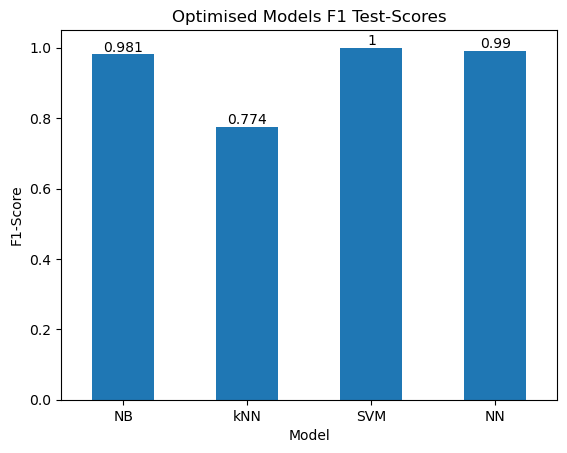

In [124]:
#Models with ideal hyperparameters from b)
nb = MultinomialNB(alpha = 0.01).fit(X_train_vec, y_train)
knn = KNeighborsClassifier(p = 2, n_neighbors = 3).fit(X_train_vec, y_train)
svm = SVC(C = 0.1, gamma = 50, kernel = 'linear').fit(X_train_vec, y_train)
nn = MLPClassifier(activation = 'tanh', hidden_layer_sizes = 5, 
                   learning_rate_init = 0.01, max_iter = 100, 
                   solver = 'sgd').fit(X_train_vec_nn, y_train_nn)

#computing F1-scores for each model
classifiers = [nb, knn, svm]
f1_scores_list = []
for c in classifiers:
    test_pred = c.predict(test_vec)
    f1_scores_list.append(f1_score(y_test, test_pred, average='macro'))

f1_scores_list.append(f1_score(y_test_nn, nn.predict(X_test_vec_nn), average='macro'))

#Model vs. F1 Data Frame
f1_scores = pd.DataFrame(data = {'Model': ['NB', 'kNN', 'SVM', 'NN'], 'F1_score': f1_scores_list})
f1_scores.F1_score = f1_scores.F1_score.round(3)

f1_scores

ax = f1_scores.plot.bar(x = 'Model', y = 'F1_score', rot=0)
ax.set_ylabel('F1-Score')
ax.set_title('Optimised Models F1 Test-Scores')
ax.bar_label(ax.containers[0])
ax.get_legend().remove()

## Discussion
Upon optimising our models we observe that the K-Nearest Neighbours Classifier is still the weakest model of the four we are evaluating. SVM has had the biggest improvement with the new hyperparameters achieving a perfect F1-Score on the test data of 1.00. For the second-best classifier, Neural Networks and Naive Bayes achieve a very similar score. Considering the Naive Bayes Classifier giving a slightly smaller difference between train, validation, and test accuracy as seen in 3b, we would favour it as more effective than the Neural Network Classifier. However, with a bigger training dataset, the Neural Network Classifier could very well outperform Naive Bayes, as seen in 3a, where the models predictions drastically improved (in terms of accuracy) as the training set became larger.